# HW3 Seq2Seq

In this question, you will use Seq2seq autoencoder model to generate patient EHR embedding and use these embeddigns to conduct unsupervised patient clustering.

---

In [302]:
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [303]:
# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [304]:
DATA_PATH = "../HW3-Seq2Seq-lib/data/"

assert os.path.isdir(DATA_PATH)

---

## 1 Load MIMIC-III data

We will be using the *ADMISSIONS*, *DIAGNOSES_ICD*, and *PATIENTS* tables from [MIMIC-III](https://mimic.physionet.org/gettingstarted/access/) dataset. Here is an overview of the three tables.

-  *ADMISSIONS*: Define a patient’s hospital admission, HADM_ID.
- *DIAGNOSES_ICD*: Contains ICD diagnoses for patients, most notably ICD-9 diagnoses.
- *PATIENTS*: Defines each SUBJECT_ID in the database, i.e. defines a single patient.

The data has been preprocessed for you. Let us load them and take a look.

In [305]:
pids = pickle.load(open(f'{DATA_PATH}/mimic3.pids', 'rb'))
dates = pickle.load(open(f'{DATA_PATH}/mimic3.dates', 'rb'))
morts = pickle.load(open(f'{DATA_PATH}/mimic3.morts', 'rb'))
seqs = pickle.load(open(f'{DATA_PATH}/mimic3.3digitICD9.seqs', 'rb'))
types = pickle.load(open(f'{DATA_PATH}/mimic3.3digitICD9.types', 'rb'))
rtypes = dict([(v,k) for k,v in types.items()])

assert len(pids) == len(dates) == len(morts) == len(seqs) == 7537
assert len(types) == 942

where

- `pids`: contains the patient ids
- `dates`: contains a list of admission dates for each patient
- `morts`: contains the mortality information (0: alive, 1: dead)
- `seqs`: contains a list of ICD-9 labels for admission of each patient
- `types`: contains the map from 3-digit ICD-9 codes to ICD-9 labels
- `rtypes`: contains the map from ICD-9 labels to 3-digit ICD-9 codes

Let us take a patient as an example.

In [306]:
# take the 5-th patient as an example

print("Patient ID:", pids[5])
print("Mortality:", morts[5])
print("# of admissions:", len(dates[5]))
for visit in range(len(dates[5])):
    print(f"\t{visit}-th admission date:", dates[5][visit])
    print(f"\t{visit}-th admission diagnosis labels:", seqs[5][visit])
    print(f"\t{visit}-th admission diagnosis codes:", [rtypes[label] for label in seqs[5][visit]])

Patient ID: 362
Mortality: 0
# of admissions: 2
	0-th admission date: 2112-07-10 02:31:00
	0-th admission diagnosis labels: [77, 3, 78, 79, 45, 15, 80, 81]
	0-th admission diagnosis codes: ['D_E885', 'D_401', 'D_397', 'D_396', 'D_599', 'D_427', 'D_253', 'D_852']
	1-th admission date: 2112-07-28 17:08:00
	1-th admission diagnosis labels: [77, 3, 5, 15, 17, 81]
	1-th admission diagnosis codes: ['D_E885', 'D_401', 'D_424', 'D_427', 'D_428', 'D_852']


Note that `seqs` is a list of list of list. That is, `seqs[i][j][k]` gives you the k-th diagnosis codes for the j-th visit for the i-th patient.

And you can look up the meaning of the ICD-9 code online. For example, `D_427` represetns *cardiac dysrhythmias*.

Further, let see number of mortalities cases.

In [307]:
print("number of mortalities:", sum(morts))
print("ratio of mortalities: %.2f" % (sum(morts) / len(morts)))

number of mortalities: 2825
ratio of mortalities: 0.37


For the sake of computational efficiency, we will only use the diagnosis that appears more than or equal to 50 times in `seqs`. We need first store these frequent diagnosis labels into list `freq_codes`.

In [308]:
freq_codes = []

'''
Append all codes that appears more than 50 times in freq_codes list.
'''

cnt_dict = {}
for i in range(len(seqs)):
    for j in range(len(seqs[i])):
        for each_code in seqs[i][j]:
            if each_code not in cnt_dict:
                cnt_dict[each_code] = 1
            else:
                cnt_dict[each_code] += 1

for each_code in cnt_dict:
    if cnt_dict[each_code] >= 50:
        freq_codes.append(each_code)
        
assert len(freq_codes) == 360

In [309]:
code2idx = {code: idx for idx, code in enumerate(freq_codes)}

## 2 Build the dataset [20 points]

### 2.1 Custom the dataset  [5 points]
First, let us implement a custom dataset using PyTorch class `Dataset`, which will characterize the key features of the dataset we want to generate.

We will use the sequences of diagnosis codes `seqs` as input and mortality `morts` as output.

Note that we can still use `TorchText` as it provides a generic way to deal with sequential data. But we will implement the `Dataset` from scratch this time so that you can have more hands-on experience.

In [310]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    
    def __init__(self, seqs, morts):
        self.x = seqs
        self.y = morts
    
    def __len__(self):
        
        """
        TODO: Return the number of samples (i.e. patients).
        """
        
        # your code here
        return len(self.x)
#         raise NotImplementedError
    
    def __getitem__(self, index):
        
        """
        TODO: Generates one sample of data.
        
        Note that you DO NOT need to covert them to tensor as we will do this later.
        """
        
        # your code here
        return self.x[index], self.y[index]
        
         

In [311]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

dataset = CustomDataset(seqs, morts)
assert len(dataset) == 7537



### 2.2 Collate Function [10 points]

As you note that, we do not convert the data to tensor in the built `CustomDataset`. Instead, we will do this using a collate function `collate_fn()`. 

This collate function `collate_fn()` will be called by `DataLoader` after fetching a list of samples using the indices from `CustomDataset` to collate the list of samples into batches.

For example, assume the `DataLoader` gets a list of two samples.

```
[ [ [0, 1, 2], [4, 0] ], 
  [ [2, 3], [1], [1, 4] ] ]
```

where the first sample has two visits `[0, 1, 2]` and `[4, 0]` and the second sample has three visits `[2, 3]`, `[1]`, and `[4, 1]`.

The collate function `collate_fn()` is supposed to pad them into a multi-hot vector with shape (2, 3, 5), where 3 is the maximum number of visits, and 5 is the number of total diagnosis codes.

``` 
[ [ [1, 1, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0] ],
  [ [0, 0, 1, 1, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1] ] ]
```

Further, the padding information will be stored in a mask with the shape (2, 3), where 1 indicates that the visit at this position is from the original input, and 0 indicates that the visit at this position is the padded value.

```
[ [1, 1, 0], 
  [1, 1, 1] ]
```

We need to pad the sequences into the same length so that we can do batch training on GPU. And we also need this mask so that when training, we can ignored the padded value as they actually do not contain any information.

We only keep the codes that in the `freq_codes` list and drop other codes.

In [312]:
print(code2idx)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 96: 94, 97: 95, 98: 96, 99: 97, 100: 98, 102: 99, 103: 100, 104: 101, 105: 102, 106: 103, 107: 104, 108: 105, 109: 106, 110: 107, 111: 108, 113: 109, 114: 110, 115: 111, 116: 112, 117: 113, 118: 114, 119: 115, 120: 116, 121: 117, 122: 118, 123: 119, 124: 120, 125: 12

In [313]:
def collate_fn(data):
    """
    Collate the the list of samples into batches. For each patient, you need to pad the diagnosis
        sequences to the sample shape (max # visits, len(freq_codes)). The padding infomation
        is stored in `mask`.
    
    Arguments:
        data: a list of samples fetched from `CustomDataset`
        
    Outputs:
        x: a tensor of shape (# patiens, max # visits, len(freq_codes)) of type torch.float
        masks: a tensor of shape (# patiens, max # visits) of type torch.bool
        y: a tensor of shape (# patiens) of type torch.float
        
    Note that you can obtains the list of diagnosis codes and the list of mortality labels
        using: `sequences, labels = zip(*data)`
    """
    sequences, labels = zip(*data)
    num_patients = len(sequences)
    num_visits = [len(patient) for patient in sequences]
    max_num_visits = max(num_visits)
    
    y = torch.tensor(labels, dtype=torch.float)
    x = torch.zeros((num_patients, max_num_visits, len(freq_codes)), dtype=torch.float) 
#     print(x[0])

    for i_patient, patient in enumerate(sequences):
        for j_visit, visit in enumerate(patient):
            for code in visit:
                """
                TODO: 1. check if code is in freq_codes;
                      2. obtain the code index using code2idx;
                      3. set the correspoindg element in x to 1.
                """
                if code in freq_codes:     
                    x[i_patient][j_visit][code2idx[code]] = 1
                
                                      
    masks = torch.sum(x, dim=-1) > 0
    print((x.shape, masks.shape))
    return x, masks, y

In [314]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=10, collate_fn=collate_fn)
loader_iter = iter(loader)
x, masks, y = next(loader_iter)

assert x.dtype == torch.float
assert y.dtype == torch.float
assert masks.dtype == torch.bool

assert x.shape == (10, 5, 360)
assert y.shape == (10,)
assert masks.shape == (10, 5)

assert x[0][0].sum() == 8
assert masks[0].sum() == 2



(torch.Size([10, 5, 360]), torch.Size([10, 5]))


Now we have `CustomDataset` and `collate_fn()`. Let us split the dataset into training and validation sets.

In [315]:
from torch.utils.data.dataset import random_split

split = int(len(dataset)*0.8)

lengths = [split, len(dataset) - split]
train_dataset, val_dataset = random_split(dataset, lengths)

print("Length of train dataset:", len(train_dataset))
print("Length of val dataset:", len(val_dataset))

Length of train dataset: 6029
Length of val dataset: 1508


### 2.3 DataLoader [5 points]

Now, we can load the dataset into the data loader.

In [316]:
from torch.utils.data import DataLoader

def load_data(train_dataset, val_dataset, collate_fn):
    
    '''
    TODO: Implement this function to return the data loader for  train and validation dataset. 
    Set batchsize to 32. Set `shuffle=True` only for train dataloader.
    
    Arguments:
        train dataset: train dataset of type `CustomDataset`
        val dataset: validation dataset of type `CustomDataset`
        collate_fn: collate function
        
    Outputs:
        train_loader, val_loader: train and validation dataloaders
    
    Note that you need to pass the collate function to the data loader `collate_fn()`.
    '''
    
    # your code here
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
#     raise NotImplementedError
    
    return train_loader, val_loader

In [317]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

train_loader, val_loader = load_data(train_dataset, val_dataset, collate_fn)
assert len(train_loader) == 189



## 3 Building the Seq2seq model [50 points]

The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which commonly use a *recurrent neural network* (RNN) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector*. We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* to output the target by generating it one word at a time.

![](img/seq2seq1.png)

The above image shows an example translation. 

In this task, we will build a naive GRU seq2seq autoencoder model. The input to the encoder will be the multi-hot code vector at each timestep. The decoder will try to reconstruct the input at each timestep based on the hidden embedding of the encoder network. In this way, we can store the longitudinal patient EHR data in a vector (i.e., the hidden state of the encoder network).

### 3.1 Build the encoder model [15 points]

First, we will build the encoder model using ```nn.GRU```. The input will be fed into the GRU and get final hidden state as the output of the encoder. Importantly, you need to use `masks` to mask out the padding visits. So, let us first preform the mask selection.

In [318]:
def get_last_visit(hidden_states, masks):
    """
    Obtain the hidden state for the last true visit (not padding visits)

    Arguments:
        hidden_states: the hidden states of each visit of shape (batch_size, # visits, embedding_dim)
        masks: the padding masks of shape (batch_size, # visits, # diagnosis codes)

    Outputs:
        last_hidden_state: the hidden state for the last true visit of shape (batch_size, embedding_dim)
    """
    
    last_true_visits = torch.sum(masks, dim=-1) - 1
    last_true_visits = last_true_visits.view(-1, 1, 1).expand(hidden_states.size())
    true_h_n = torch.gather(hidden_states, dim=1, index=last_true_visits)[:, -1, :]
    return true_h_n

Next we will build the GRU encoder

In [319]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        """
        TODO: Define the RNN using `nn.GRU()`; 
              The `input_size` is 360. Set `hidden_size` to 128. Set `batch_first` to True.
        """
        self.rnn = None
        # your code here
        self.rnn = nn.GRU(input_size = 360 ,hidden_size = 128, batch_first = True)
#         raise NotImplementedError
    
    def forward(self, x, masks):
        """
        TODO:
            1. Pass the sequence through the RNN layer;
            2. Obtain the hidden state at the last visit.
               Use `get_last_visit()`;
            
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # visits, # diagnosis codes)
            masks: the padding masks of shape (batch_size, # visits)

        Outputs:
            states: probabilities of shape (batch_size, 128)
        """
        # your code here
        output, h_n = self.rnn(x)
        states = get_last_visit(output, masks)
        return states
#         raise NotImplementedError

In [320]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

torch.manual_seed(42)

encoder = Encoder()

layer_types_to_check = [nn.GRU]

for layer_type in layer_types_to_check:
    no_layer = True
    for child in encoder.children():
        for layer in child.modules():
            if(isinstance(layer, layer_type)):
                no_layer = False
    assert no_layer is False

loader = DataLoader(dataset, batch_size=10, collate_fn=collate_fn)
loader_iter = iter(loader)
x, masks, y = next(loader_iter)
assert encoder(x, masks).shape == (10, 128), "output shape is not (batch_size, 128)!"
assert round(encoder(x, masks)[0][0].item(), 4) == 0.0577, "output value is wrong!"



(torch.Size([10, 5, 360]), torch.Size([10, 5]))


### 3.2 Build the decoder model [15 points]

Next, we'll build our decoder, which will also be a GRU.

The `Decoder` class does a single step of decoding, i.e. it ouputs single reconstructed results per time-step. The GRU layer will receive the initial hidden state from the encoder outputs. The first input to the decoder will be a zero vector, and then the decoder will try to reconstruct the input at timestep 1. For the following timestep, the input will be the output of the decoder from last timestep.

Within the `forward` method, we accept a batch of inputs and previous hidden states. As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. We `unsqueeze` the inputs to add a length dimension of 1.

In [321]:
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        """
        TODO: Define the RNN using `nn.GRU()`; 
              The `input_size` is 360. Set `hidden_size` to 128. Set `batch_first` to True.
        """
        self.rnn = None
        # your code here
        self.rnn = nn.GRU(
            input_size = 360,
            hidden_size = 128,
            batch_first = True
        )
#         raise NotImplementedError
        
        self.linear1 = nn.Linear(128, 128)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(128, 360)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, hiddens):
        """
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # diagnosis codes)
            hiddens: the padding masks of shape (batch_size, 128)

        Outputs:
            preds: the reconstructed results of shape (batch_size, # diagnosis codes)
            hiddens: the hidden state of the GRU with shape (batch_size, 128)
        """
        
        # Unsqueeze the input at dimension 1 -> (batch_size, 1, # diagnosis codes)
        x = x.unsqueeze(1)
        # Unsqueeze the hiddens at dimension 0; -> (1, batch_size, 128)
        hiddens = hiddens.unsqueeze(0)
        
        """
        TODO:
            1. Pass the input through the RNN layer; Remember to set the initial hidden states of GRU `h_0` to `hiddens`
            2. Squeeze the hidden states h_n of RNN at dimension 0.
        """
        h_n = None
        # your code here
        preds,h_n=self.rnn(x,hiddens) 
        h_n = h_n.squeeze(0)
#         raise NotImplementedError
        
        preds = self.linear1(h_n)
        preds = self.act(preds)
        preds = self.linear2(preds)
        preds = self.sigmoid(preds)
        return preds, h_n

In [322]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

torch.manual_seed(42)

decoder = Decoder()

layer_types_to_check = [nn.GRU, nn.Linear, nn.Sigmoid]

for layer_type in layer_types_to_check:
    no_layer = True
    for child in decoder.children():
        for layer in child.modules():
            if(isinstance(layer, layer_type)):
                no_layer = False
    assert no_layer is False

x = torch.randn(10, 360)
hiddens = torch.randn(10, 128)
assert decoder(x, hiddens)[0].shape == (10, 360), "preds is not of shape (batch_size, 360)!"
assert decoder(x, hiddens)[1].shape == (10, 128), "h_n is not of shape (batch_size, 128)!"
assert round(decoder(x, hiddens)[0][0][0].item(), 4) == 0.5177, "preds value is wrong!"
assert round(decoder(x, hiddens)[1][0][0].item(), 4) == -0.3921, "h_n value is wrong!"



### 3.3 Connect the encoder and decoder [20 points]

For the final part of the implemenetation, we'll implement the seq2seq model

The `Seq2Seq` model takes in an `Encoder` and a `Decoder`.

Our `forward` method takes the source sequence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth input in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the output that the model predicted as the next input to the model.  

The first input to the decoder is a zero vector.

During each iteration of the loop, we:
- pass the input, previous hidden states into the decoder
- receive a prediction and next hidden state from the decoder
- decide if we are going to "teacher force" or not
    - if we do, the next `input` is the ground-truth input in the sequence
    - if we don't, the next `input` is the predicted input in the sequence
    
Once we've made all of our predictions, we return our tensor full of predictions.

For example, So our `inputs` and `outputs` of the decoder look something like ($x_t$ is the orinal input, $\hat{x}_t$ is the reconstructed input):

If not use teach force:

$$\begin{align*}
\text{inputs} &= [0, \hat{x}_1, \hat{x}_2]\\
\text{outputs} &= [\hat{x}_1, \hat{x}_2, \hat{x}_3]
\end{align*}$$

If use teach force:

$$\begin{align*}
\text{inputs} &= [0, x_1, x_2]\\
\text{outputs} &= [\hat{x}_1, \hat{x}_2, \hat{x}_3]
\end{align*}$$

In [326]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder, teacher_forcing_ratio):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, x, masks):
        
        """
        STEP:
            1. Pass the input through the encoder; save the output to `hidden`;
            2. Pass the first input (0) and encoder hidden state to the decoder;
            3. Use for-loop to 
                   1. Use `random.random()` to decide whether to use teacher force
                   2. Pass the previous output `cur_pred` / the ground truth input `x[:, t-1, :]` 
                      and previous hidden state `h` to the decoder;
                   3. Save `cur_pred`, the output of the decoder, to a list.
            4. Use torch.stack to convert the list to a tensor and 
               reshape it to (batch_size, # visits, # diagnosis codes)
            
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # visits, # diagnosis codes)
            masks: the padding masks of shape (batch_size, # visits)

        Outputs:
            preds: the reconstructed results of shape (batch_size, # visits, # diagnosis codes)
        """
        
        preds = []
        
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        
        """
        TODO: perform step 1
        """
        hidden = None
        # your code here
        hidden = self.encoder(x, masks)
#         raise NotImplementedError
        
        # step 2
        x_decode = torch.zeros(batch_size, 360)
        cur_pred, h = self.decoder(x_decode, hidden)
        preds.append(cur_pred)
        
        for t in range(1, seq_len):
            # step 3.1
            teacher_force = random.random() < self.teacher_forcing_ratio
            
            """
            TODO: perform step 3.2
            """
            # your code here
            if teacher_force:
                cur_pred, h=self.decoder(x[:, t-1, :], h)
            else:
                cur_pred, h = self.decoder(cur_pred, h) 
#             raise NotImplementedError
            
            # step 3.3
            preds.append(cur_pred)
        
        # step 4
        return torch.stack(preds).permute(1,0,2)

In [327]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''


torch.manual_seed(42)
random.seed(42)

seq2seq = Seq2Seq(encoder, decoder, 0.5)

layer_types_to_check = [nn.GRU, nn.Linear, nn.Sigmoid]

for layer_type in layer_types_to_check:
    no_layer = True
    for child in seq2seq.children():
        for layer in child.modules():
            if(isinstance(layer, layer_type)):
                no_layer = False
    assert no_layer is False

x = torch.randn(10, 5, 360)
masks = torch.ones(10, 5, dtype=torch.bool)
assert seq2seq(x, masks).shape == (10, 5, 360), "output shape should be (batch_size, # visits, # diagnosis codes)!"
assert round(seq2seq(x, masks)[0][0][0].item(), 4) == 0.4908, "output value is wrong!"



## 4 Model training [15 points]

### 4.1 Loss and optimizer
Because we are reconstructing original input, we use BCELoss as loss function. 

In [328]:
# set reduction='none' because we need to mask out the padding values manually.
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-2)

### 4.2 Evaluate

In [329]:
from sklearn.metrics import f1_score, accuracy_score


def eval(model, val_loader):
    
    """
    Evaluate the model.
    
    Arguments:
        model: the seq2seq model
        val_loader: validation dataloader
        
    Outputs:
        f1: overall f1 score
        accuracy: overall accuracy score; 
        use np.round to round the preds to calculate the metrics.
        
    We have implement this for you.
    """
    
    model.eval()

    x_pred = []
    x_true = []
    for x, masks, y in val_loader:
        x_hat = model(x, masks).detach().numpy()
        x_hat = np.round(x_hat)
        for i in range(len(x_hat)):
            for j in range(len(x_hat[i])):
                if masks[i, j] == 1:
                    x_pred.append(x_hat[i,j])
                    x_true.append(x.numpy()[i,j])
    
    f = f1_score(y_pred=x_pred, y_true=x_true, average='micro')
    acc = accuracy_score(y_pred=x_pred, y_true=x_true)
    return f, acc

### 4.3 Training

In [330]:
def train(model, train_loader, val_loader, n_epochs):
    """
    Train the model.
    
    Arguments:
        model: the RNN model
        train_loader: training dataloder
        val_loader: validation dataloader
        n_epochs: total number of epochs
        
    We have implement this for you.
    """
    
    seq2seq.train()
    for epoch in range(n_epochs):
        train_loss = 0
        for x, masks, y in train_loader:
            optimizer.zero_grad()
            x_hat = seq2seq(x, masks)
            loss = criterion(x_hat, x)
            loss = loss * masks.float().unsqueeze(-1)
            loss = torch.mean(torch.sum(loss, dim=[1,2]))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))
        f, acc = eval(model, val_loader)
        print('Epoch: %d \t Validation f: %.2f, acc: %.2f'%(epoch+1, f, acc))

    
# number of epochs to train the model
n_epochs = 20

train(seq2seq, train_loader, val_loader, n_epochs)

(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 21, 360]), torch.Size([32, 21]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 15, 360]), torch.Size([32, 15]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 6, 360]), torch

(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 16, 360]), torch.Size([32, 16]))
(torch.Size([32, 34, 360]), torch.Size([32, 34]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([13, 4, 360]), torch.Size([13, 4]))
Epoch: 1 	 Training Loss: 111.837084
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 

(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 16, 360]), torch.Size([32, 16]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.S

(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Siz

(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 6, 360]), tor

(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 34, 360]), torch.Size([32, 34]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 8, 360]),

(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 24, 360]), torch.Size([32, 24]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 3, 360]), torch.Size([32, 3]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 8, 360]), t

(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 3, 360]), torch.Size([32, 3]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 16, 360]), torch.Size([32, 16]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 4, 360]), torch.Siz

(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch

(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 24, 360]), torch.Size([32, 24]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360

(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 20, 360]), torch.Size([32, 20]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 3, 360]), torch.Size([32, 3]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 6, 360]), torch.S

(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Siz

(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 31, 360]), torch.Size([32, 31]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([13, 5, 360]), torch.Size([13, 5]))
Epoch: 9 	 Training Loss: 55.087075
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 3, 360]), torch.Size([32, 3]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 12, 360]), torch.Size([32, 12

(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 31, 360]), torch.Size([32, 31]))
(torch.Size([32, 3, 360]), torch.Size([32, 3]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 24, 360]), torch.Size([32, 24]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 3, 360]), torch.Size([32, 3]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.S

(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 42, 360]), torch.Size([32, 42]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 34, 360]), 

(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([4, 3, 360]), torch.Size([4, 3]))
Epoch: 11 	 Validation f: 0.63, acc: 0.06
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size(

(torch.Size([32, 16, 360]), torch.Size([32, 16]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 20, 360]), torch.Size([32, 20]))
(torch.Size([32, 34, 360]), torch.Size([32, 34]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 16, 360]), to

(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch

(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 42, 360]), torch.Size([32, 42]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 23, 360]), torch.Size([32, 23]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 9, 360]), torch

(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch

(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 14, 360]), torch.Size([32, 14]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Siz

(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), tor

(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 7, 360]), torch.S

(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([13, 8, 360]), torch.Size([13, 8]))
Epoch: 17 	 Training Loss: 45.034515
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 3, 360]), torch.Size([32, 3]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]

(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 16, 360]), torch.Size([32, 16]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 15, 360]), torch.Size([32, 15]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 12, 360]), torch.

(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), t

(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([4, 3, 360]), torch.Size([4, 3]))
Epoch: 19 	 Validation f: 0.64, acc: 0.08
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 31, 360]), torch.Size([32, 31]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 6, 360]), torch.Siz

(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 21, 360]), torch.Size([32, 21]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 6, 360]), torch.S

In [331]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''



'\nAUTOGRADER CELL. DO NOT MODIFY THIS.\n'

## 5 Unsupervised patient clustering [15 points]

After training a seq2seq model, we can use the encoder to generate patient embeddings. These embeddings can be used for unsupervised tasks.

In [332]:
def get_embeddings(model, data_loader):
    """
    Use trained encoder model to get patient embeddings.
    
    Arguments:
        model: trained seq2seq model
        data_loader: dataloder
        
    Return:
        embeddings: numpy array that contains patient embeddings.
        labels: numpy array that contains patient mortality label.
    
    We have implement this for you.
    """
    
    seq2seq.eval()
    embeddings = []
    labels = []
    for x, masks, y in data_loader:
        cur_embd = seq2seq.encoder(x, masks)
        embeddings += list(cur_embd.detach().numpy())
        labels += list(y.numpy())
        
    return np.array(embeddings), np.array(labels)

    
embeddings, labels = get_embeddings(seq2seq, val_loader)

(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 3, 360]), torch.Size([32, 3]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 10, 360]), torch.Size([32, 10]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 9, 360]), torch.Size([32, 9]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 12, 360]), torch.Size([32, 12]))
(torch.Size([32, 4, 360]), torch.Size([32, 4]))
(torch.Size([32, 5, 360]), torch.Size([32, 5]))
(torch.Size([32, 7, 360]), torch.Size([32, 7]))
(torch.Size([32, 6, 360]), torch.Size([32, 6]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 13, 360]), torch.Size([32, 13]))
(torch.Size([32, 17, 360]), torch.Size([32, 17]))
(torch.Size([32, 11, 360]), torch.Size([32, 11]))
(torch.Size([32, 8, 360]), torch.Size([32, 8]))
(torch.Size([32, 7, 360]),

Next we will use KMeans algorithm to cluster these embeddings

In [338]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans

def get_clusters(embeddings):
    """
    TODO: 1. Use K-means to generate patient clusters. (set K to 2)
          2. Use calinski harabaz score to evaluate clustering results
    
    Arguments:
        embeddings: obtained patient embeddings
        
    Return:
        labels: K-means clustering labels
        
    Hint: Use sklearn.cluster.KMeans and sklearn.metrics.calinski_harabasz_score.
    
    """
    
    # your code here
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)
    
    calinski_harabasz_score(embeddings, labels)
    
    return labels
#     raise NotImplementedError
    
cluster_labels = get_clusters(embeddings)

In [339]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

assert cluster_labels.shape == (1508, )



Let us use T-SNE to visualize the embeddings and clustering results.

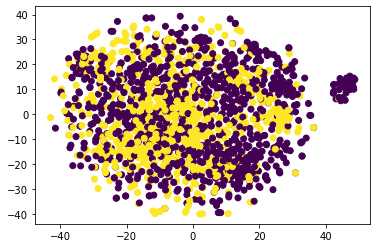

In [340]:
from sklearn import manifold
import matplotlib.pyplot as plt

tsne = manifold.TSNE(n_components=2, init='pca', random_state=42)
tsne_embd = tsne.fit_transform(embeddings)

plt.scatter(tsne_embd[:,0], tsne_embd[:,1], c=labels)
plt.show()

The cluster result is not really good due to the limited resources. Feel free to explore more on this topic in project!